# Week 4: Multi-class Classification

Welcome to this assignment! In this exercise, you will get a chance to work on a multi-class classification problem. You will be using the [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset, which contains 28x28 images of hands depicting the 26 letters of the english alphabet. 

You will need to pre-process the data so that it can be fed into your convolutional neural network to correctly classify each image as the letter it represents.


Let's get started!

In [39]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

Download the training and test sets (the test set will actually be used as a validation set):

In [40]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 254MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 156MB/s]


Define some globals with the path to both files you just downloaded:

In [41]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

Unlike previous assignments, you will not have the actual images provided, instead you will have the data serialized as `csv` files.

Take a look at how the data looks like within the `csv` file:

In [42]:
with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

As you can see, each file includes a header (the first line) and each subsequent data point is represented as a line that contains 785 values. 

The first value is the label (the numeric representation of each letter) and the other 784 values are the value of each pixel of the image. Remember that the original images have a resolution of 28x28, which sums up to 784 pixels.

 ## Parsing the dataset
 
 Now complete the `parse_data_from_input` below.

 This function should be able to read a file passed as input and return 2 numpy arrays, one containing the labels and one containing the 28x28 representation of each image within the file. These numpy arrays should have type `float64`.

 A couple of things to keep in mind:
 
- The first line contains the column headers, so you should ignore it.

- Each successive line contains 785 comma-separated values between 0 and 255
  - The first value is the label

  - The rest are the pixel values for that picture

  
  Tips:

- `csv.reader` returns an iterable that returns a row of the csv file in each iteration.
Following this convention, row[0] has the label and row[1:] has the 784 pixel values.

- To reshape the arrays (going from 784 to 28x28), you can use functions such as [`np.array_split`](https://numpy.org/doc/stable/reference/generated/numpy.array_split.html) or [`np.reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html).

- For type conversion of the numpy arrays, use the method [`np.ndarray.astype`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.astype.html).

In [43]:
# GRADED FUNCTION: parse_data_from_input
def parse_data_from_input(filename):
  with open(filename) as file:
    ### START CODE HERE

    # Use csv.reader, passing in the appropriate delimiter
    # Remember that csv.reader can be iterated and returns one line in each iteration
    csv_reader = csv.reader(file, delimiter=",")
    next(csv_reader, None)
    label_arr = list()
    img_arr = list()
    for row in csv_reader:
      label_arr.append(row[0])
      img_arr.append(np.array(row[1:]).reshape(28,28))
    
    labels = np.array(label_arr, dtype=np.float64)
    images = np.array(img_arr, dtype=np.float64)

    
    ### END CODE HERE

    return images, labels

In [44]:
# Test your function
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape}")
print(f"Training labels has shape: {training_labels.shape}")
print(f"Validation images has shape: {validation_images.shape}")
print(f"Validation labels has shape: {validation_labels.shape}")

Training images has shape: (27455, 28, 28)
Training labels has shape: (27455,)
Validation images has shape: (7172, 28, 28)
Validation labels has shape: (7172,)


**Expected Output:**
```
Training images has shape: (27455, 28, 28)
Training labels has shape: (27455,)
Testing images has shape: (7172, 28, 28)
Testing labels has shape: (7172,)
```

## Visualizing the numpy arrays

Now that you have converted the initial csv data into a format that is compatible with computer vision tasks, take a moment to actually see how the images of the dataset look like:

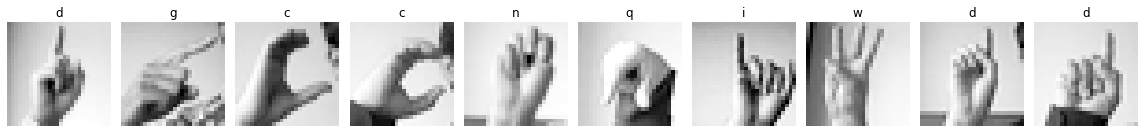

In [45]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

## Creating the generators for the CNN

Now that you have successfully organized the data in a way that can be easily fed to Keras' `ImageDataGenerator`, it is time for you to code the generators that will yield batches of images, both for training and validation. For this complete the `train_val_generators` function below.

Some important notes:

- The images in this dataset come in the same resolution so you don't need to set a custom `target_size` in this case. In fact, you can't even do so because this time you will not be using the `flow_from_directory` method (as in previous assignments). Instead you will use the [`flow`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow) method.
- You need to add the "color" dimension to the numpy arrays that encode the images. These are black and white images, so this new dimension should have a size of 1 (instead of 3, which is used when dealing with colored images). Take a look at the function [`np.expand_dims`](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) for this.

In [46]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  ### START CODE HERE

  # In this section you will have to add another dimension to the data
  # So, for example, if your array is (10000, 28, 28)
  # You will need to make it (10000, 28, 28, 1)
  # Hint: np.expand_dims
  training_images = np.expand_dims(training_images, axis=-1)
  validation_images = np.expand_dims(validation_images, axis=-1)

  # Instantiate the ImageDataGenerator class 
  # Don't forget to normalize pixel values 
  # and set arguments to augment the images (if desired)
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                     rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode="nearest")


  # Pass in the appropriate arguments to the flow method
  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32) 

  
  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(rescale = 1./255)

  # Pass in the appropriate arguments to the flow method
  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32) 

  ### END CODE HERE

  return train_generator, validation_generator

In [47]:
# Test your generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


**Expected Output:**
```
Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)
```

## Coding the CNN

One last step before training is to define the architecture of the model that will be trained.

Complete the `create_model` function below. This function should return a Keras' model that uses the `Sequential` or the `Functional` API.

The last layer of your model should have a number of units that corresponds to the number of possible categories, as well as the correct activation function.

Aside from defining the architecture of the model, you should also compile it so make sure to use a `loss` function that is suitable for multi-class classification.

**Note that you should use no more than 2 Conv2D and 2 MaxPooling2D layers to achieve the desired performance.**

In [48]:
def create_model():

  ### START CODE HERE       

  # Define the model
  # Use no more than 2 Conv2D and 2 MaxPooling2D
  model = tf.keras.models.Sequential([
                               tf.keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(28,28,1)),
                               tf.keras.layers.MaxPooling2D(2,2),
                               tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                               tf.keras.layers.MaxPooling2D(2,2),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dropout(0.2),
                               #tf.keras.layers.Dense(512, activation='relu'),
                               tf.keras.layers.Dense(1024, activation='relu'),
                               tf.keras.layers.Dense(26, activation='softmax')])

  model.compile(optimizer = 'rmsprop',
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

  ### END CODE HERE       
  
  return model

In [49]:
# Save your model
model = create_model()

# Train your model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
858/858 [==============================] - 20s 22ms/step - loss: 2.5476 - accuracy: 0.2216 - val_loss: 1.4554 - val_accuracy: 0.4879
Epoch 2/15
858/858 [==============================] - 18s 21ms/step - loss: 1.5802 - accuracy: 0.4912 - val_loss: 0.8355 - val_accuracy: 0.7135
Epoch 3/15
858/858 [==============================] - 18s 21ms/step - loss: 1.1173 - accuracy: 0.6348 - val_loss: 0.6492 - val_accuracy: 0.7780
Epoch 4/15
858/858 [==============================] - 19s 22ms/step - loss: 0.8830 - accuracy: 0.7076 - val_loss: 0.3950 - val_accuracy: 0.8645
Epoch 5/15
858/858 [==============================] - 18s 21ms/step - loss: 0.7446 - accuracy: 0.7546 - val_loss: 0.2840 - val_accuracy: 0.8882
Epoch 6/15
858/858 [==============================] - 18s 21ms/step - loss: 0.6391 - accuracy: 0.7871 - val_loss: 0.1913 - val_accuracy: 0.9296
Epoch 7/15
858/858 [==============================] - 18s 21ms/step - loss: 0.5688 - accuracy: 0.8126 - val_loss: 0.1532 - val_accuracy:

Now take a look at your training history:

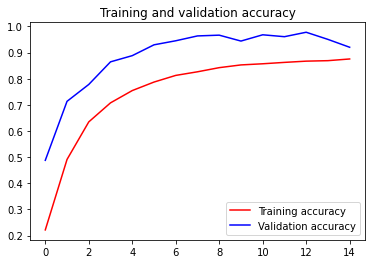

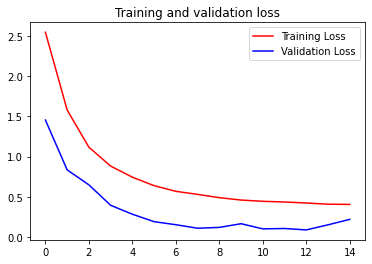

In [50]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

You will not be graded based on the accuracy of your model but try making it as high as possible for both training and validation, as an optional exercise, **after submitting your notebook for grading**.

A reasonable benchmark is to achieve over 99% accuracy for training and over 95% accuracy for validation within 15 epochs. Try tweaking your model's architecture or the augmentation techniques to see if you can achieve these levels of accuracy.

You need to submit this notebook for grading. To download it, click on the `File` tab in the upper left corner of the screen then click on `Download` -> `Download .ipynb`. You can name it anything you want as long as it is a valid `.ipynb` (jupyter notebook) file.

**Congratulations on finishing this week's assignment!**

You have successfully implemented a convolutional neural network that is able to perform multi-class classification tasks! Nice job!

**Keep it up!**